In [19]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
# Get the base path of the script
base_path = os.getcwd()
helper_functions_path = base_path + "/modules"
sys.path.insert(0, helper_functions_path)
from DataPreparer import DataPreparer
from collections import Counter

#Models
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,StackingClassifier,BaggingClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, accuracy_score

# Load the tracks clean dataset

In [21]:
dim_tracks_df = pd.read_excel('./datasets/spotify_datasets.xlsx', sheet_name='dim_tracks')
dim_tracks_df.head()

track_id                  track_name  album_id primary_genre  \
0  5SuOikwiRyPMVoIQDJUgSV                      Comedy      8086         j-pop   
1  4qPNDBW1i3p13qLCt0Ki3A            Ghost - Acoustic     14777         chill   
2  1iJBSr7s7jYXzM8EGcbK5b              To Begin Again     39115      acoustic   
3  6lfxq3CG4xtTiEg7opyCyx  Can't Help Falling In Love      8566      acoustic   
4  5vjLSffimiIP26QG5WcN2K                     Hold On     16876      acoustic   

   duration_ms  explicit key_signature  time_signature  danceability  energy  \
0       230666     False   C#/Db Minor               4         0.676  0.4610   
1       149610     False   C#/Db Major               4         0.420  0.1660   
2       210826     False       C Major               4         0.438  0.3590   
3       201933     False       C Major               3         0.266  0.0596   
4       198853     False       D Major               4         0.618  0.4430   

   key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    1    -6.746     0       0.1430        0.0322          0.000001    0.3580   
1    1   -17.235     1       0.0763        0.9240          0.000006    0.1010   
2    0    -9.734     1       0.0557        0.2100          0.000000    0.1170   
3    0   -18.515     1       0.0363        0.9050          0.000071    0.1320   
4    2    -9.681     1       0.0526        0.4690          0.000000    0.0829   

   valence    tempo  
0    0.715   87.917  
1    0.267   77.489  
2    0.120   76.332  
3    0.143  181.740  
4    0.167  119.949

In [23]:
#Pick a random set of tracks to be used later
random_test_df = dim_tracks_df.sample(1000)

random_test_df.to_csv('./datasets/sample_music_dataset.csv',index=False)

# Drop the sampled rows from the original DataFrame
dim_tracks_df = dim_tracks_df.drop(random_test_df.index)

In [25]:
dim_tracks_df.shape

(88578, 19)

In [27]:
dim_tracks_df.dtypes

track_id             object
track_name           object
album_id              int64
primary_genre        object
duration_ms           int64
explicit               bool
key_signature        object
time_signature        int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

In [29]:
#Convert some multi-valued numerical columns into object type for one-hot encoding
dim_tracks_df['time_signature'] = dim_tracks_df['time_signature'].astype('object')
dim_tracks_df['key'] = dim_tracks_df['key'].astype('object')
dim_tracks_df['mode'] = dim_tracks_df['mode'].astype('object')

In [31]:
dim_tracks_df.dtypes

track_id             object
track_name           object
album_id              int64
primary_genre        object
duration_ms           int64
explicit               bool
key_signature        object
time_signature       object
danceability        float64
energy              float64
key                  object
loudness            float64
mode                 object
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

# Label Reduction

Initial dataset had 113 unique genres which could be grouped into broader genres

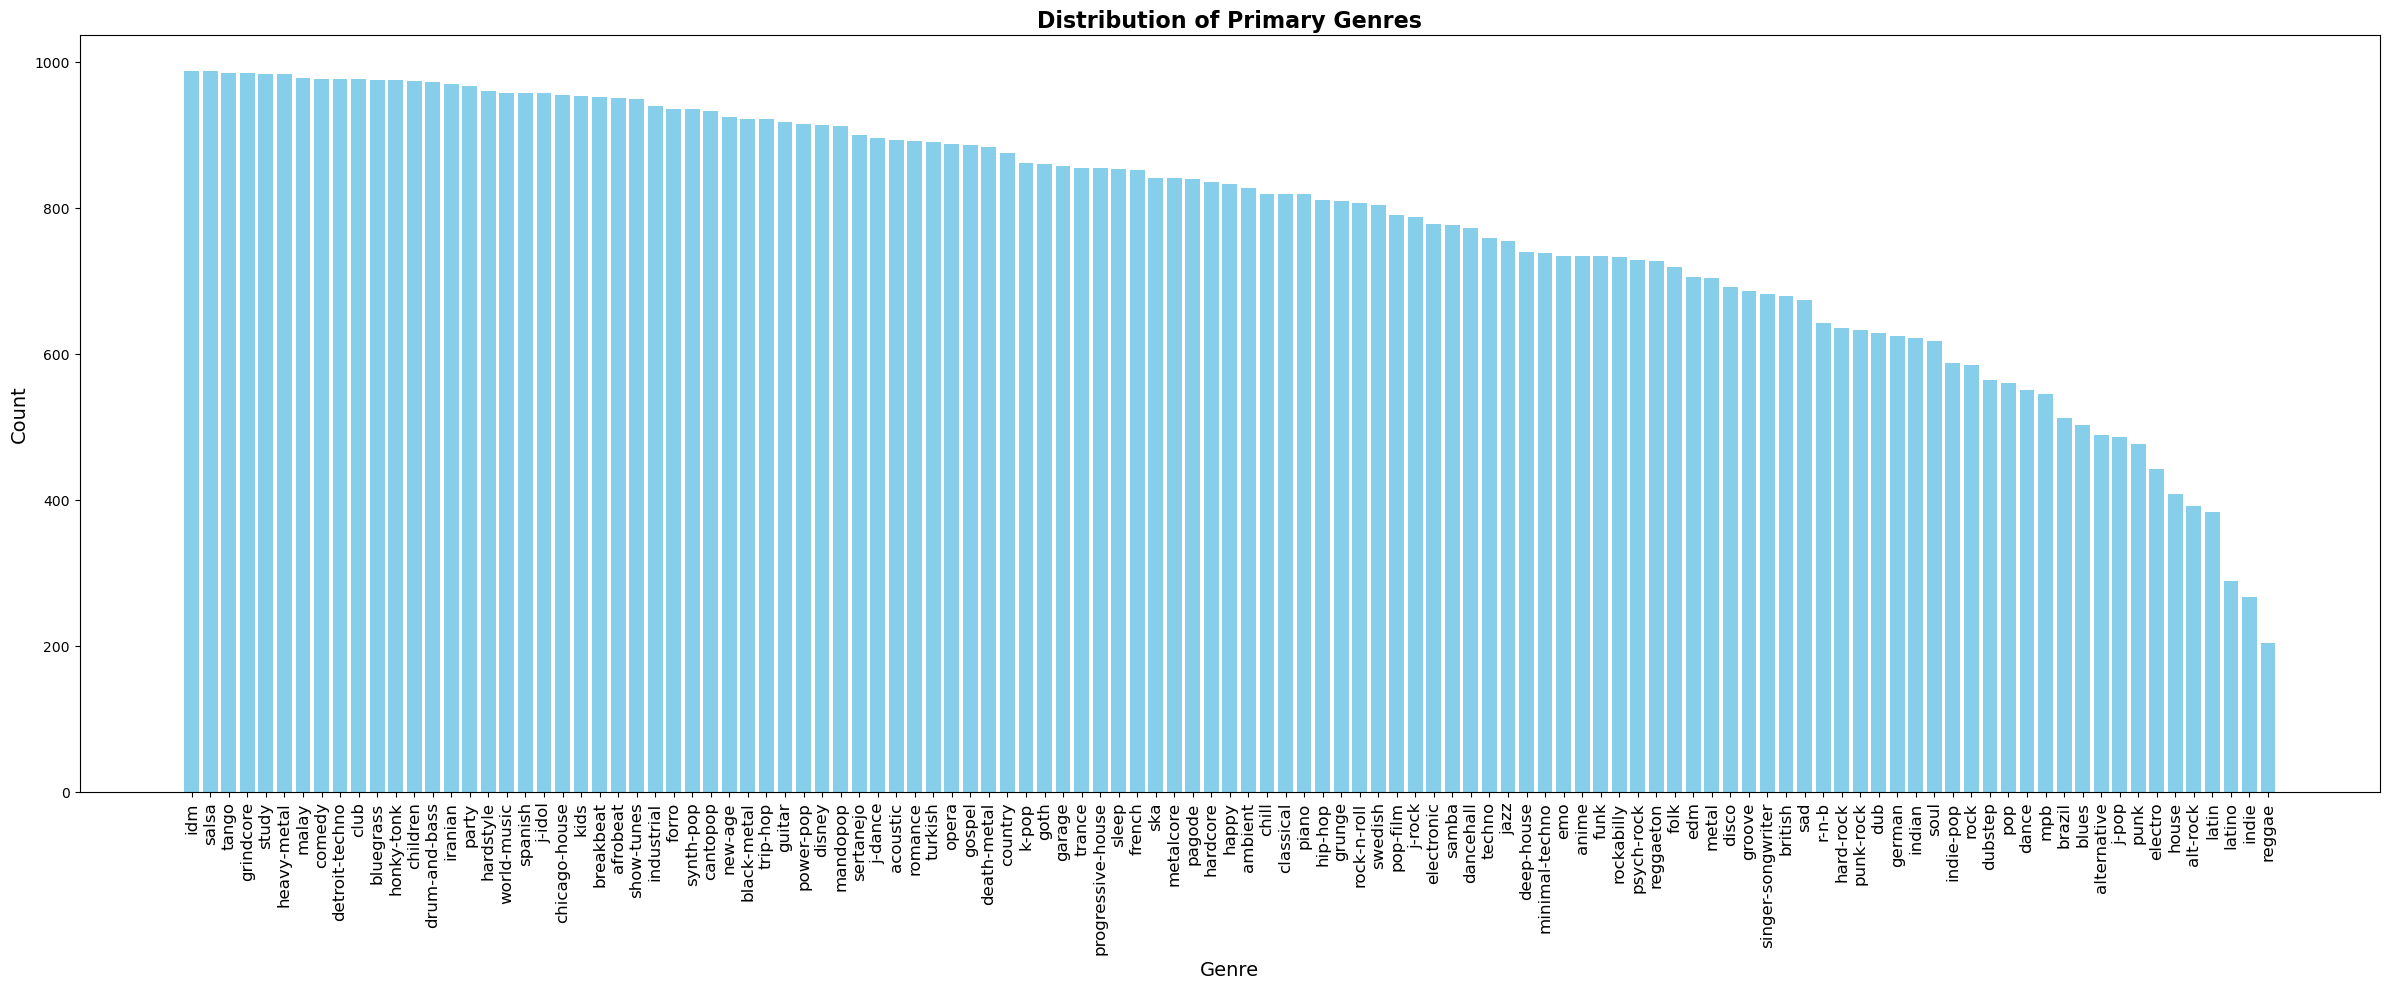

In [34]:
# Assuming dim_tracks_df is a DataFrame with a column 'primary_genre'
genre_counts = pd.DataFrame(dim_tracks_df['primary_genre'].value_counts()).reset_index()
genre_counts.columns = ['Genre', 'Count']

# Plot
plt.figure(figsize=(24, 10))
plt.bar(genre_counts['Genre'], genre_counts['Count'], color='skyblue')
plt.title('Distribution of Primary Genres', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

In [38]:
genre_mapping_df = pd.read_csv('./datasets/genre_groups.csv')
genre_mapping_df

primary_genre genre_group
0       indie-pop         Pop
1       synth-pop         Pop
2       power-pop         Pop
3             pop         Pop
4           j-pop         Pop
..            ...         ...
108    show-tunes       Niche
109      children       Niche
110          kids       Niche
111         anime       Niche
112        j-idol       Niche

[113 rows x 2 columns]

In [40]:
# Apply the mapping to create a new column
dim_tracks_df = pd.merge(dim_tracks_df,genre_mapping_df,how='inner',on='primary_genre')
dim_tracks_df

track_id                  track_name  album_id  \
0      5SuOikwiRyPMVoIQDJUgSV                      Comedy      8086   
1      4qPNDBW1i3p13qLCt0Ki3A            Ghost - Acoustic     14777   
2      1iJBSr7s7jYXzM8EGcbK5b              To Begin Again     39115   
3      6lfxq3CG4xtTiEg7opyCyx  Can't Help Falling In Love      8566   
4      5vjLSffimiIP26QG5WcN2K                     Hold On     16876   
...                       ...                         ...       ...   
88573  2C3TZjDRiAzdyViavDJ217         Sleep My Little Boy        66   
88574  1hIz5L4IB9hN3WRYPOCGPw            Water Into Light        66   
88575  6x8ZfSoqDjuNa5SVP5QjvX              Miss Perfumado      5018   
88576  2e6sXL2bYv4bSz6VTdnfLs                     Friends      7224   
88577  2hETkH7cOfqmz3LqZDHZf5                   Barbincor     24328   

      primary_genre  duration_ms  explicit key_signature time_signature  \
0             j-pop       230666     False   C#/Db Minor              4   
1             chill       149610     False   C#/Db Major              4   
2          acoustic       210826     False       C Major              4   
3          acoustic       201933     False       C Major              3   
4          acoustic       198853     False       D Major              4   
...             ...          ...       ...           ...            ...   
88573   world-music       384999     False       F Major              5   
88574   world-music       385000     False       C Minor              4   
88575   world-music       271466     False       C Minor              4   
88576   world-music       283893     False       G Major              4   
88577   world-music       241826     False   C#/Db Minor              4   

       danceability  energy key  loudness mode  speechiness  acousticness  \
0             0.676  0.4610   1    -6.746    0       0.1430        0.0322   
1             0.420  0.1660   1   -17.235    1       0.0763        0.9240   
2             0.438  0.3590   0    -9.734    1       0.0557        0.2100   
3             0.266  0.0596   0   -18.515    1       0.0363        0.9050   
4             0.618  0.4430   2    -9.681    1       0.0526        0.4690   
...             ...     ...  ..       ...  ...          ...           ...   
88573         0.172  0.2350   5   -16.393    1       0.0422        0.6400   
88574         0.174  0.1170   0   -18.318    0       0.0401        0.9940   
88575         0.629  0.3290   0   -10.895    0       0.0420        0.8670   
88576         0.587  0.5060   7   -10.889    1       0.0297        0.3810   
88577         0.526  0.4870   1   -10.204    0       0.0725        0.6810   

       instrumentalness  liveness  valence    tempo           genre_group  
0              0.000001    0.3580   0.7150   87.917                   Pop  
1              0.000006    0.1010   0.2670   77.489  Experimental/Ambient  
2              0.000000    0.1170   0.1200   76.332          Instrumental  
3              0.000071    0.1320   0.1430  181.740          Instrumental  
4              0.000000    0.0829   0.1670  119.949          Instrumental  
...                 ...       ...      ...      ...                   ...  
88573          0.928000    0.0863   0.0339  125.995                 World  
88574          0.976000    0.1050   0.0350   85.239                 World  
88575          0.000000    0.0839   0.7430  132.378                 World  
88576          0.000000    0.2700   0.4130  135.960                 World  
88577          0.000000    0.0893   0.7080   79.198                 World  

[88578 rows x 20 columns]

In [42]:
#Check for any genres unmapped
dim_tracks_df[dim_tracks_df['genre_group'].isna() == True].primary_genre.unique()

array([], dtype=object)

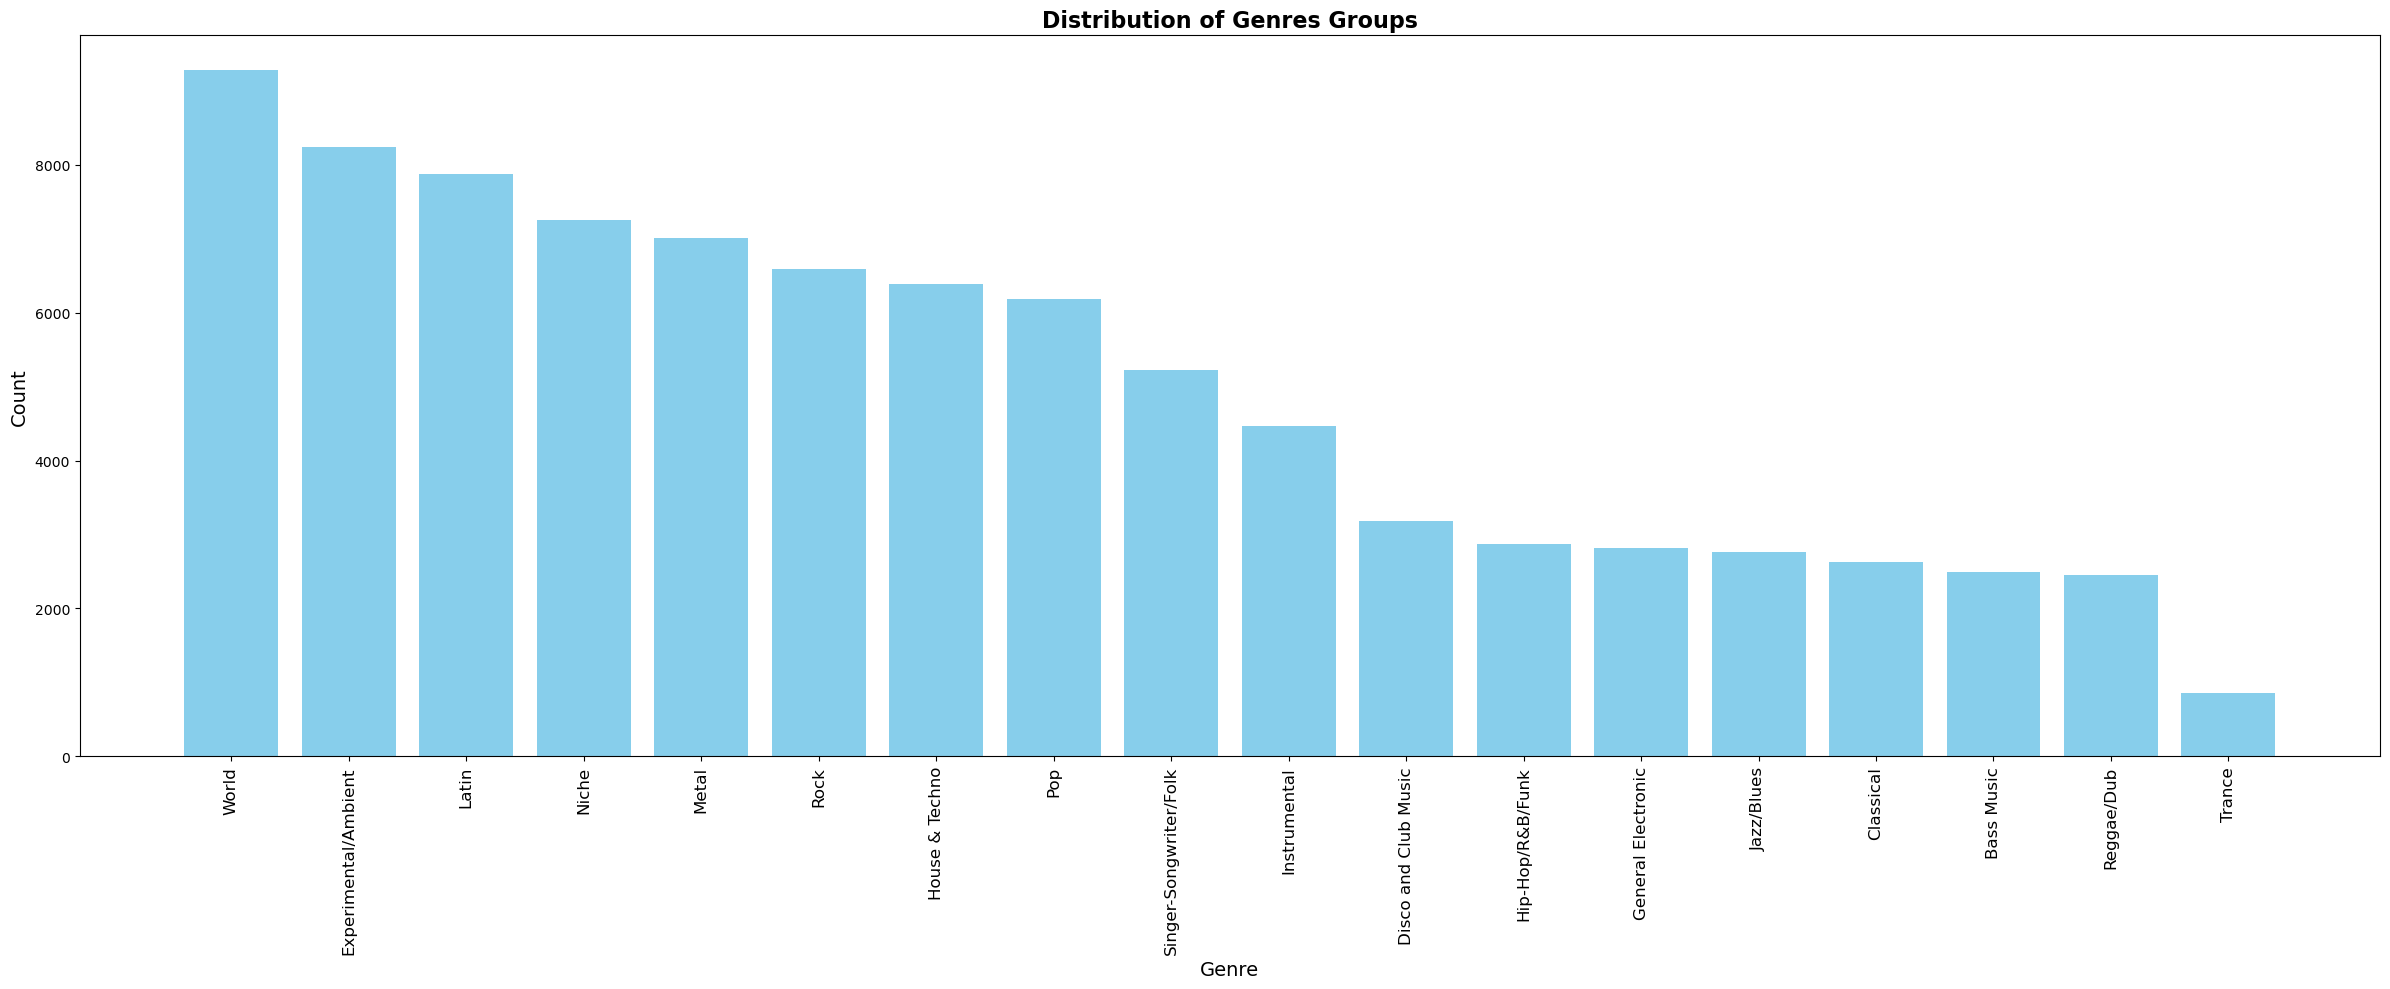

In [44]:
# Assuming dim_tracks_df is a DataFrame with a column 'primary_genre'
genre_counts = pd.DataFrame(dim_tracks_df['genre_group'].value_counts()).reset_index()
genre_counts.columns = ['Genre', 'Count']

# Plot
plt.figure(figsize=(24, 10))
plt.bar(genre_counts['Genre'], genre_counts['Count'], color='skyblue')
plt.title('Distribution of Genres Groups', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

# Feature Selection

In [47]:
#Select the feature list
feature_list = ['duration_ms',
                'danceability',
                'explicit',
                'energy', 
                'loudness', 
                'speechiness', 
                'acousticness',
                'instrumentalness', 
                'liveness', 
                'valence', 
                'tempo']

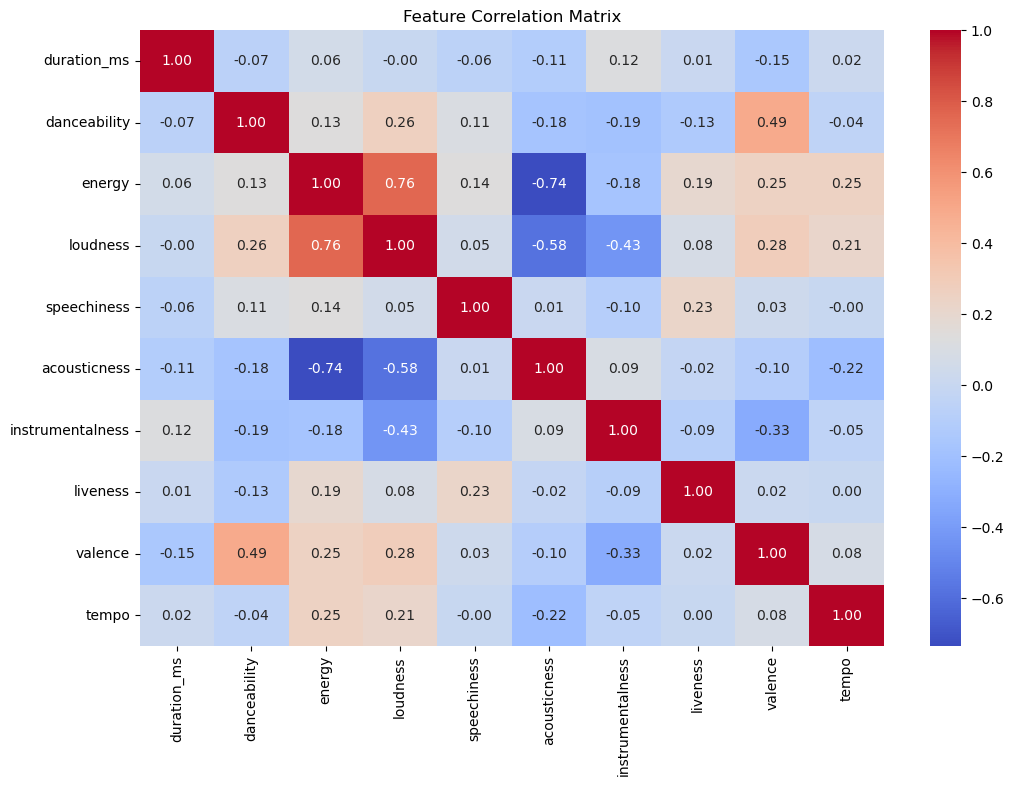

Highly correlated pairs: []


In [49]:
# Checking for multi-collinearity
feature_data = dim_tracks_df[feature_list]

# Compute the correlation matrix
correlation_matrix = feature_data.select_dtypes('number').corr(method='pearson')


# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify highly correlated pairs
high_corr_pairs = [(col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns 
                   if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.8]

print("Highly correlated pairs:", high_corr_pairs)

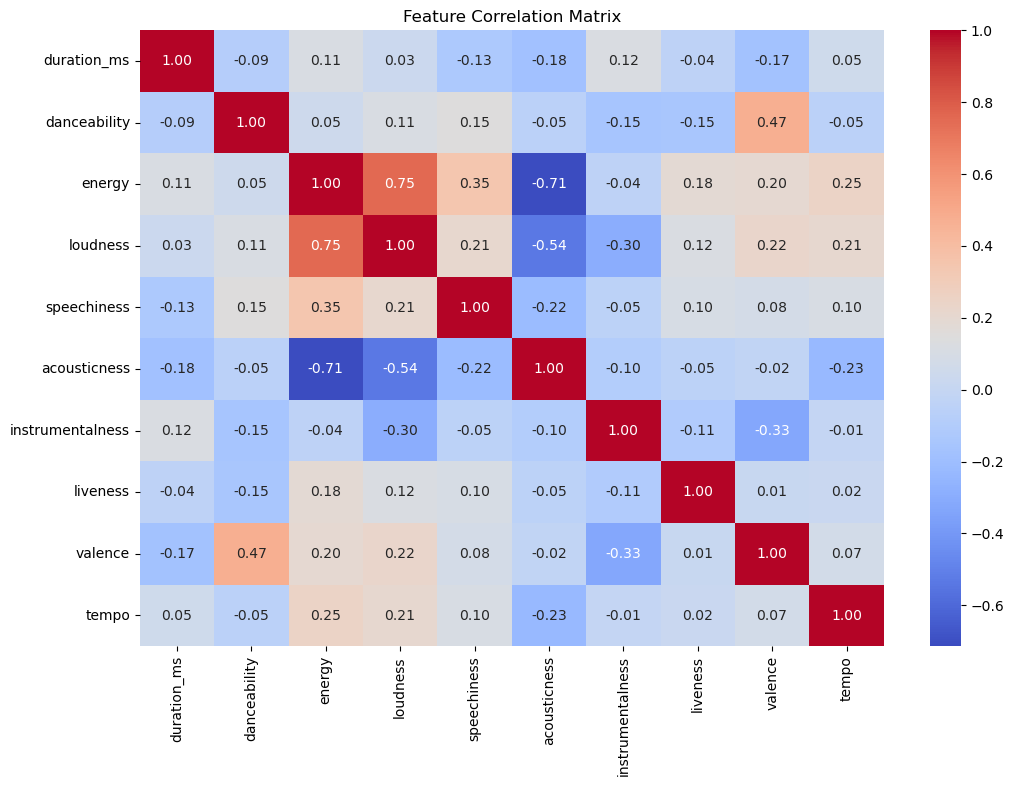

Highly correlated pairs: []


In [51]:
# Checking for multi-collinearity
feature_data = dim_tracks_df[feature_list]

# Compute the correlation matrix
correlation_matrix = feature_data.select_dtypes('number').corr(method='spearman')


# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify highly correlated pairs
high_corr_pairs = [(col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns 
                   if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.8]

print("Highly correlated pairs:", high_corr_pairs)

In [53]:
dim_tracks_df[feature_list].describe().T

count           mean            std          min  \
duration_ms       88578.0  229240.641604  111924.905838  15800.00000   
danceability      88578.0       0.563130       0.175330      0.05130   
energy            88578.0       0.635476       0.255732      0.00002   
loudness          88578.0      -8.472514       5.176387    -46.59100   
speechiness       88578.0       0.087522       0.113160      0.02210   
acousticness      88578.0       0.327816       0.338067      0.00000   
instrumentalness  88578.0       0.172585       0.323118      0.00000   
liveness          88578.0       0.216524       0.194293      0.00925   
valence           88578.0       0.470459       0.262433      0.00000   
tempo             88578.0     122.275833      29.713968     30.20000   

                           25%            50%           75%          max  
duration_ms       173138.25000  213373.500000  264335.25000  5237295.000  
danceability           0.45000       0.576000       0.69200        0.985  
energy                 0.45900       0.677000       0.85375        1.000  
loudness             -10.30100      -7.177000      -5.10300        4.532  
speechiness            0.03600       0.049000       0.08590        0.965  
acousticness           0.01710       0.187000       0.62400        0.996  
instrumentalness       0.00000       0.000057       0.09390        1.000  
liveness               0.09820       0.132000       0.27800        1.000  
valence                0.25000       0.458000       0.68300        0.995  
tempo                 99.51925     122.021000     140.08800      243.372

# Perform the data pre-processing steps

In [56]:
# Perform preprocessing steps
preparer = DataPreparer(dim_tracks_df,target='genre_group',features=feature_list)

dp = preparer.encode_categorical()

# Data Split - Train, Test

In [59]:
X_train, X_test, y_train, y_test, nf_train, nf_test, label_encoder, scaler = dp.split_data(test_size=0.2, scale_method='standard')

In [61]:
print("Training Set : {}".format(X_train.shape))
print("Test Set : {}".format(X_test.shape))

Training Set : (70862, 11)
Test Set : (17716, 11)


In [63]:
X_train[feature_list].describe().T

count          mean       std       min       25%  \
duration_ms       70862.0  1.203256e-18  1.000007 -1.947198 -0.510988   
danceability      70862.0 -6.488057e-16  1.000007 -2.911624 -0.642034   
energy            70862.0 -2.747435e-17  1.000007 -2.477029 -0.688985   
loudness          70862.0  2.165861e-16  1.000007 -7.335455 -0.351085   
speechiness       70862.0  2.767489e-17  1.000007 -0.576501 -0.454082   
acousticness      70862.0  1.347647e-16  1.000007 -0.970869 -0.920399   
instrumentalness  70862.0 -9.094610e-17  1.000007 -0.534983 -0.534983   
liveness          70862.0  7.329835e-17  1.000007 -1.065465 -0.608213   
valence           70862.0  5.013567e-17  1.000007 -1.790597 -0.837379   
tempo             70862.0 -1.925210e-17  1.000007 -3.096731 -0.760037   

                       50%       75%        max  
duration_ms      -0.144645  0.320679  45.717065  
danceability      0.075218  0.735545   2.397748  
energy            0.162130  0.853173   1.427090  
loudness          0.250920  0.650203   2.241751  
speechiness      -0.340470 -0.013725   7.710128  
acousticness     -0.415994  0.879697   1.968787  
instrumentalness -0.534803 -0.239703   2.557763  
liveness         -0.433753  0.317611   4.033262  
valence          -0.048114  0.809783   2.003213  
tempo            -0.010403  0.597082   4.072519

# Feature Engineering of Training and Test Sets

In [ ]:
def fn_feature_engineering(df):
    
    # Feature Engineering
    df['energy_loudness'] = (df['energy']) * df['loudness']
    df['energy_to_acoustic_ratio'] = df['energy'] / (df['acousticness'] + 1e-5)
    df['danceability_valence'] = df['danceability'] * df['valence']
    df['loudness_to_acousticness_ratio'] = df['loudness'] / (df['acousticness'] + 1e-5)
    df['instrumentalness_to_loudness_ratio'] = df['instrumentalness'] / (df['loudness'] + 1e-5)
    
    return df

In [ ]:
#Add the new features to the training and test sets
X_train = fn_feature_engineering(X_train)
X_test = fn_feature_engineering(X_test)

In [ ]:
correlation_matrix_new = X_train.select_dtypes('number').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_new, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Engineered Features")
plt.show()

# Feature Selection based on feature importance

In [21]:
lgb_model = LGBMClassifier(objective="multiclass", random_state=42)

#Train the ensemble model
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 70862, number of used features: 11
[LightGBM] [Info] Start training from score -3.573102
[LightGBM] [Info] Start training from score -3.512626
[LightGBM] [Info] Start training from score -3.325033
[LightGBM] [Info] Start training from score -2.373362
[LightGBM] [Info] Start training from score -3.448916
[LightGBM] [Info] Start training from score -3.427825
[LightGBM] [Info] Start training from score -2.629535
[LightGBM] [Info] Start training from score -2.988169
[LightGBM] [Info] Start training from score -3.461877
[LightGBM] [Info] Start training from score -2.420661
[LightGBM] [Info] Start training from score -2.535649
[LightGBM] [Info] Start training from score -2.503566
[LightGBM] [Info] Start training from score -2.659329
[LightGBM

LGBMClassifier(objective='multiclass', random_state=42)

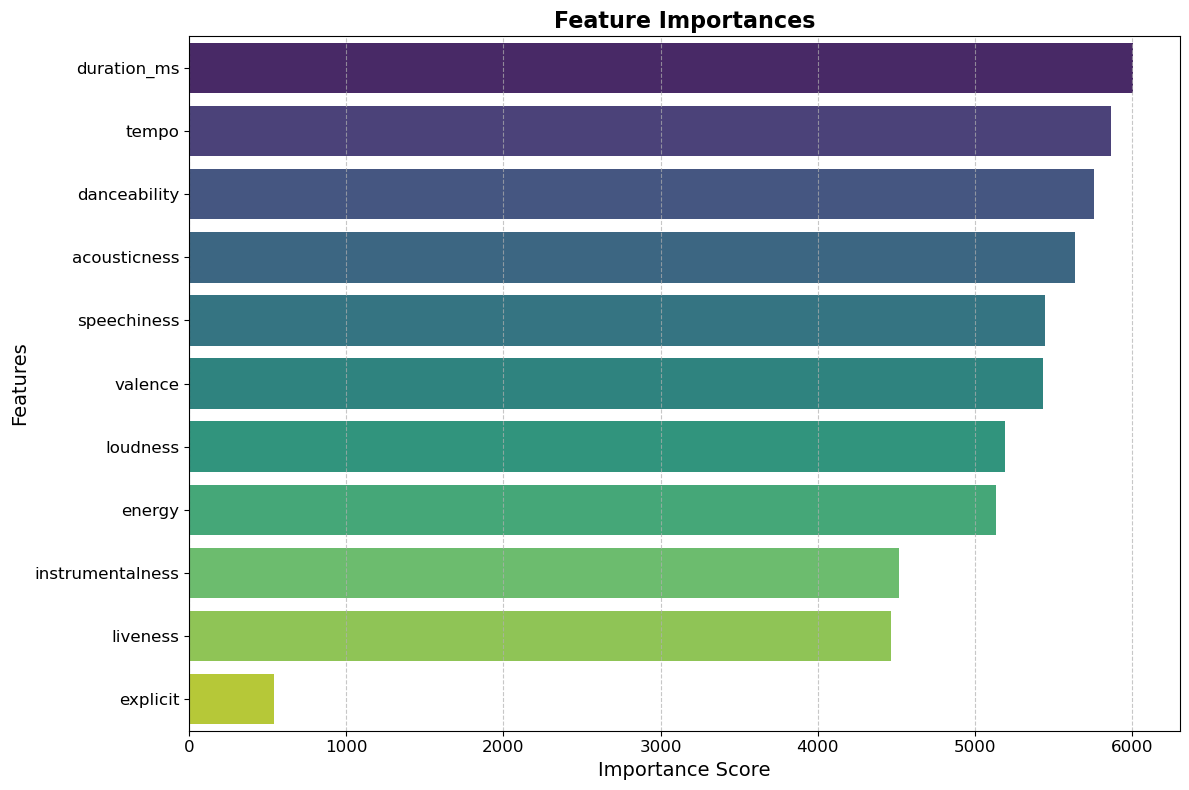

In [22]:
# Extract feature importances
feature_importances = lgb_model.feature_importances_

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Replace X_train with your feature names
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature')
plt.title('Feature Importances', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [23]:
# Calculate cumulative importance
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum()

# Retain features contributing to 99% cumulative importance
important_features = importance_df[importance_df['Cumulative_Importance'] <= 1]

print("Features to retain:", important_features['Feature'].tolist())

Features to retain: ['duration_ms', 'tempo', 'danceability', 'acousticness', 'speechiness', 'valence', 'loudness', 'energy', 'instrumentalness', 'liveness', 'explicit']


In [24]:
#Select the relevant features
new_feature_list = important_features['Feature'].tolist()

#Subset of features
X_train_subset = X_train[new_feature_list]
X_test_subset = X_test[new_feature_list]

dp.features = new_feature_list

# Handling Class Imbalance

In [36]:
#Handle Class Imbalance using oversampling of the minority class
X_resampled, y_resampled = dp.handle_class_imbalance(X_train_subset, y_train, mode='adasyn')

print("New Re-Sampled Set after Class-Imbalance Correction : {}".format(X_resampled.shape))

X_resampled, y_resampled = dp.handle_class_imbalance(X_resampled, y_resampled, mode='combo')

print("New Re-Sampled Set after Class-Imbalance Correction : {}".format(X_resampled.shape))

New Re-Sampled Set after Class-Imbalance Correction : (77644, 11)
New Re-Sampled Set after Class-Imbalance Correction : (128986, 11)


In [37]:
class_corr_labels = label_encoder.inverse_transform(y_resampled)

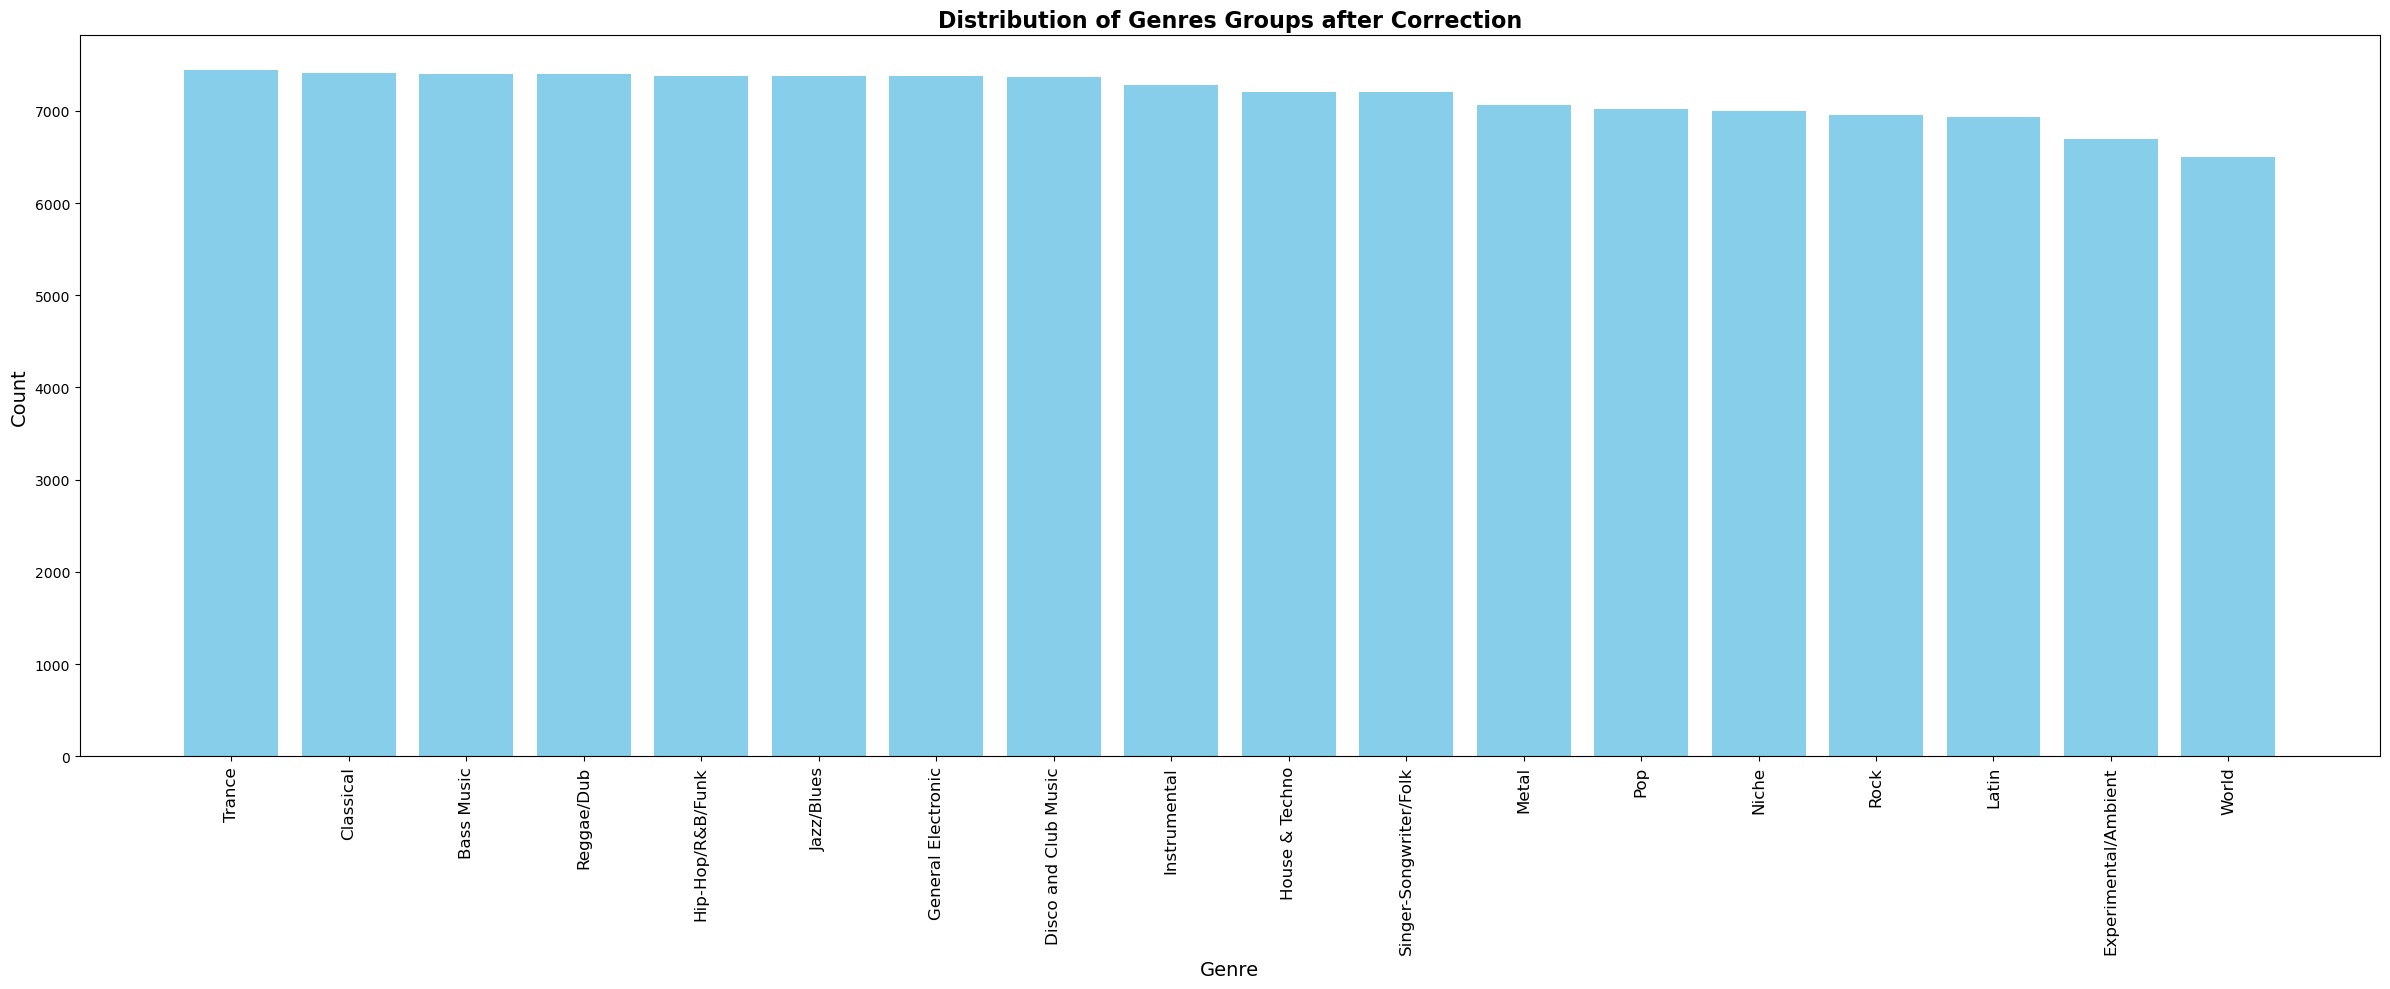

In [38]:
# Count occurrences of each label
label_counts = Counter(class_corr_labels)

# Sort labels and counts by values
sorted_labels_counts = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
labels, counts = zip(*sorted_labels_counts)

# Plot
plt.figure(figsize=(24, 10))
plt.bar(labels, counts, color='skyblue')
plt.title('Distribution of Genres Groups after Correction', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the model
gb_model = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [300, 500, 1000],
    'max_depth': [3, 5, 7]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,scoring='accuracy', cv=5, verbose=1)
grid_search.fit(X_train_subset, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


# Model Training and Prediction

In [28]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

ovr_model = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
ovr_model.fit(X_train_subset, y_train)


#Predict on Test Data
y_pred_encoded = ovr_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded, )
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.32
F1-Score: 0.33


In [ ]:
ovr_model = OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=10, 
                                                       min_samples_split=5,min_samples_leaf=2, random_state=42))
ovr_model.fit(X_train_subset, y_train)


#Predict on Test Data
y_pred_encoded = ovr_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded, )
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

In [ ]:
#Random Forest with best parameters
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train_subset, y_train)

#Predict on Test Data
y_pred_encoded = rf_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded, )
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

In [ ]:
#Random Forest with best parameters
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=30, random_state=42)

rf_model.fit(X_train_subset, y_train)

#Predict on Test Data
y_pred_encoded = rf_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded, )
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

In [ ]:
#XGBoost with best parameters
xgb_model = XGBClassifier(objective='multi:softmax', random_state=42)

xgb_model.fit(X_train_subset, y_train)

#Predict on Test Data
y_pred_encoded = xgb_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

In [ ]:
#XGBoost with best parameters
xgb_model = XGBClassifier(objective='multi:softmax', max_depth=10, learning_rate=0.1,
                          n_estimators=500, random_state=42)

xgb_model.fit(X_train_subset, y_train)

#Predict on Test Data
y_pred_encoded = xgb_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

In [ ]:
#CatBoost with best parameters
cat_model = CatBoostClassifier(loss_function='MultiClass',random_state=42, verbose=0)

cat_model.fit(X_train_subset, y_train)

#Predict on Test Data
y_pred_encoded = cat_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

In [ ]:
#CatBoost with best parameters
cat_model = CatBoostClassifier(loss_function='MultiClass',learning_rate=0.1, depth=10, 
                               bagging_temperature=1.5, n_estimators=1000,random_state=42, verbose=0)

cat_model.fit(X_train_subset, y_train)

#Predict on Test Data
y_pred_encoded = cat_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

In [ ]:
#LGBMClassifier with best parameters
lgbm_model = LGBMClassifier(objective='multiclass', random_state=42, verbose=0)


lgbm_model.fit(X_train_subset, y_train)

#Predict on Test Data
y_pred_encoded = lgbm_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

In [ ]:
#LGBMClassifier with best parameters
lgbm_model = LGBMClassifier(objective='multiclass',  learning_rate=0.1,     
                            n_estimators=1000, max_depth=30, random_state=42, verbose=0)


lgbm_model.fit(X_train_subset, y_train)

#Predict on Test Data
y_pred_encoded = lgbm_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

In [29]:
#Random Forest with best parameters
rf_model = RandomForestClassifier(random_state=42)

#XGBoost with best parameters
xgb_model = XGBClassifier(objective='multi:softmax', random_state=42)

#CatBoost with best parameters
cat_model = CatBoostClassifier(loss_function='MultiClass',random_state=42, verbose=0)


#LGBMClassifier with best parameters
lgbm_model = LGBMClassifier(objective='multiclass',random_state=42, verbose=0)

#Estimator List
estimator_list = [('rf', rf_model),
                  ('xgb', xgb_model),
                  ('cb', cat_model),
                  ('lgb', lgbm_model),]



In [39]:
#Random Forest with best parameters
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=30, random_state=42)

#XGBoost with best parameters
xgb_model = XGBClassifier(objective='multi:softmax', max_depth=8, learning_rate=0.1, n_estimators=1000, random_state=42)

#CatBoost with best parameters
cat_model = CatBoostClassifier(loss_function='MultiClass',learning_rate=0.1, depth=10, bagging_temperature=1.5, 
                               n_estimators=1000,random_state=42, verbose=0)


#LGBMClassifier with best parameters
lgbm_model = LGBMClassifier(objective='multiclass', learning_rate=0.1, n_estimators=1000, max_depth=30, 
                            random_state=42, verbose=0)

#Estimator List
estimator_list = [('rf', rf_model),  A - 20 , B - 30, C-50       A , B , C ---> C
                  ('xgb', xgb_model), A - 20 , B - 40, C-50.   
                  ('cb', cat_model),A - 20 , B - 30, C-50
                  ('lgb', lgbm_model),]A - 20 , B - 30, C-50

# Voting Classifier

In [31]:
#Setup the model pipeline
ensemble_model = VotingClassifier(estimators=estimator_list, voting='soft')

#Train the ensemble model
ensemble_model.fit(X_train_subset, y_train)

#Predict on Test Data
y_pred_encoded = ensemble_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.48
F1-Score: 0.48


## Class Imbalance corrected

In [40]:
#Setup the model pipeline
ensemble_model = VotingClassifier(estimators=estimator_list, voting='soft')

#Train the ensemble model
ensemble_model.fit(X_resampled, y_resampled)

#Predict on Test Data
y_pred_encoded = ensemble_model.predict(X_test_subset)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred_encoded, average='weighted')
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.47
F1-Score: 0.47


In [41]:
final_dataset_df = dp.revert_to_original(X_test_subset,y_test,y_pred_encoded,nf_test,scaler,label_encoder)
final_dataset_df

track_id            track_name  album_id primary_genre  \
0      71wciO7F9Ro8J4vq1lvfru             Strangers     35267           dub   
1      60mrGpCA4OIUuRLwi4T5Nm         Broken Summer      6199    electronic   
2      6CPkYHBAibi126IvgDOBAv  Nadariyum Noorumalai     10008     classical   
3      2bniagIrUDKNmMs8nDpUac     Ueno Park Sunsets     26442         study   
4      2E3y6X63fbZCYJGELwRAWQ             The Voice      1259         opera   
...                       ...                   ...       ...           ...   
17711  2wSblDewPborsJ2YjA15K5  Detrás de un cristal     23878       spanish   
17712  1MfvnCnhKwAuiYE3ILKzQj           Most Wanted     24705     dancehall   
17713  0MNMTMcvctrTAjf1I378ra                  Mute     14250     grindcore   
17714  2hkbyz2lNgp9FWYepJ8A2G               Znamení     43430           emo   
17715  1hnWusq6OGMuRsKvcmFLl8                 土瓜灣情歌     46335      cantopop   

      key_signature time_signature key mode  duration_ms  danceability  ...  \
0           C Major              4   0    1     187875.0         0.508  ...   
1       A#/Bb Minor              4  10    0     183778.0         0.683  ...   
2           E Major              4   4    1     210466.0         0.337  ...   
3       C#/Db Major              4   1    1     137600.0         0.568  ...   
4           A Minor              3   9    0     185373.0         0.201  ...   
...             ...            ...  ..  ...          ...           ...  ...   
17711   G#/Ab Major              4   8    1     223093.0         0.511  ...   
17712   G#/Ab Minor              4   8    0     192028.0         0.745  ...   
17713   F#/Gb Major              4   6    1      33286.0         0.200  ...   
17714       C Major              3   0    1     139598.0         0.524  ...   
17715       C Major              4   0    1     143360.0         0.315  ...   

       loudness  speechiness  acousticness  instrumentalness  liveness  \
0        -8.557       0.0373        0.1540      5.040000e-03    0.1270   
1       -10.720       0.0841        0.0918      6.340000e-06    0.1490   
2       -19.676       0.0432        0.9830      8.800000e-01    0.3510   
3        -9.291       0.0419        0.6890      9.630000e-01    0.1920   
4        -8.312       0.0476        0.7890      3.510000e-04    0.1040   
...         ...          ...           ...               ...       ...   
17711    -6.431       0.0293        0.6830      2.775558e-17    0.1400   
17712    -4.469       0.1680        0.7090      2.775558e-17    0.1070   
17713    -3.390       0.2280        0.0000      6.380000e-01    0.8280   
17714   -13.153       0.2060        0.7890      2.775558e-17    0.0814   
17715    -9.643       0.0330        0.8770      2.360000e-01    0.1640   

       valence    tempo  explicit  original_genre_group predicted_genre_group  
0        0.171  130.098     False            Reggae/Dub                 World  
1        0.554   81.006     False    General Electronic            Reggae/Dub  
2        0.870   81.438     False             Classical             Classical  
3        0.193  150.064     False          Instrumental          Instrumental  
4        0.372  188.190     False             Classical             Classical  
...        ...      ...       ...                   ...                   ...  
17711    0.314  139.860     False                 World                   Pop  
17712    0.815  106.149     False            Reggae/Dub                 Latin  
17713    0.000   56.228     False                 Metal                 Metal  
17714    0.465  135.171     False                  Rock                 Niche  
17715    0.483  144.236     False                   Pop  Experimental/Ambient  

[17716 rows x 21 columns]

# Model Evaluation

In [42]:
# Accuracy
accuracy = accuracy_score(final_dataset_df['original_genre_group'], final_dataset_df['predicted_genre_group'])
print(f"Accuracy: {accuracy:.2f}")

# Generate Classification Report
print("Classification Report:")
print(classification_report(final_dataset_df['original_genre_group'], final_dataset_df['predicted_genre_group']))

# Cohen's Kappa
kappa = cohen_kappa_score(final_dataset_df['original_genre_group'], final_dataset_df['predicted_genre_group'])
print(f"Cohen's Kappa: {kappa:.2f}")

# F1-Score
f1 = f1_score(final_dataset_df['original_genre_group'], final_dataset_df['predicted_genre_group'], average='weighted')
print(f"Weighted F1-Score: {f1:.2f}")


Accuracy: 0.47
Classification Report:
                        precision    recall  f1-score   support

            Bass Music       0.49      0.54      0.51       497
             Classical       0.49      0.65      0.55       528
  Disco and Club Music       0.41      0.44      0.43       637
  Experimental/Ambient       0.44      0.32      0.37      1650
    General Electronic       0.33      0.39      0.36       563
      Hip-Hop/R&B/Funk       0.35      0.36      0.36       575
        House & Techno       0.64      0.65      0.64      1278
          Instrumental       0.56      0.54      0.55       893
            Jazz/Blues       0.42      0.47      0.45       556
                 Latin       0.58      0.60      0.59      1574
                 Metal       0.61      0.70      0.65      1403
                 Niche       0.55      0.46      0.50      1449
                   Pop       0.37      0.38      0.38      1240
            Reggae/Dub       0.24      0.36      0.29       489
 

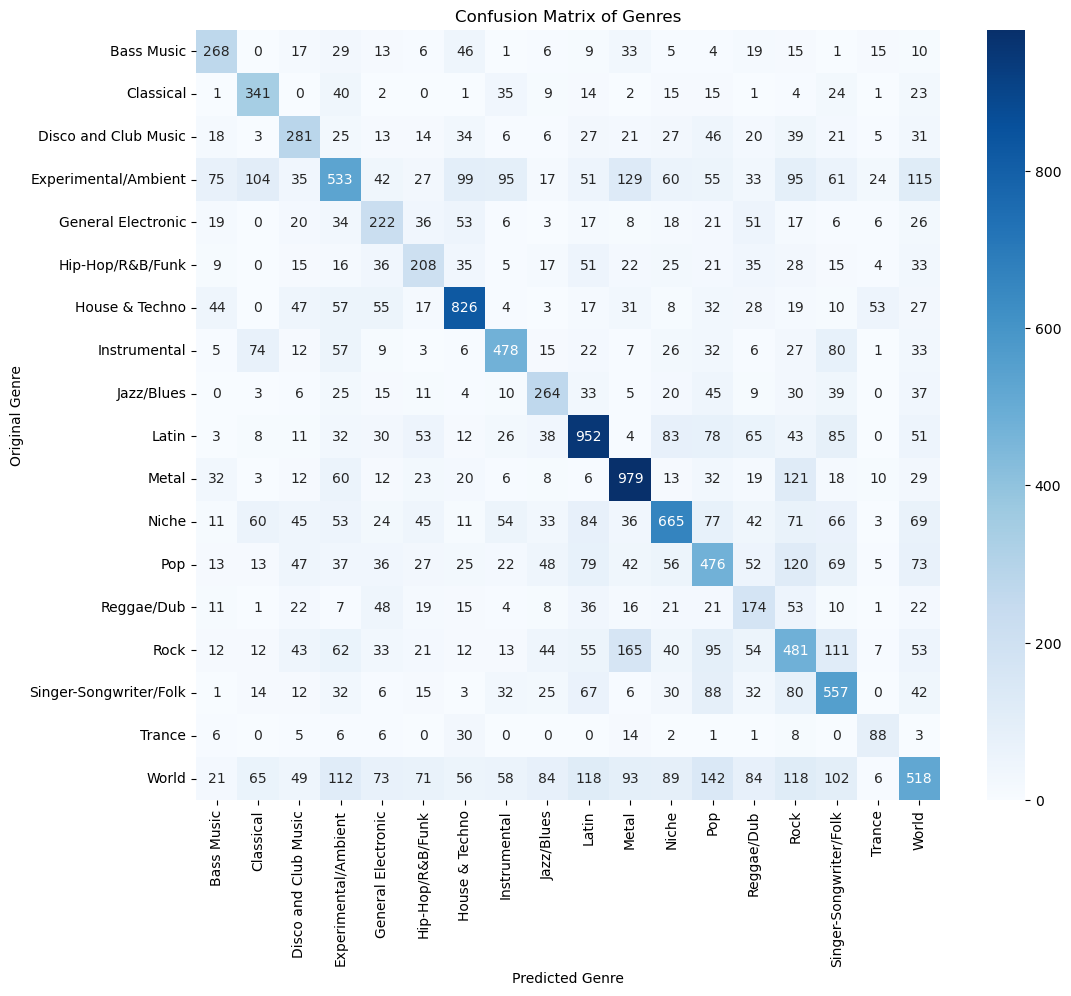

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode genres into numeric labels
encoder = LabelEncoder()
original_encoded = encoder.fit_transform(final_dataset_df['original_genre_group'])
predicted_encoded = encoder.transform(final_dataset_df['predicted_genre_group'])

# Compute confusion matrix
cm = confusion_matrix(original_encoded, predicted_encoded)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Genre')
plt.ylabel('Original Genre')
plt.title('Confusion Matrix of Genres')
plt.show()


# Deep Learning Model

In [ ]:
# import deep learning libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential

In [ ]:
# build model
deepl_model = keras.models.Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(X_resampled.shape[1],)),
    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dense(len(set(y_resampled)), activation="softmax"),
    
])

# compile model  
deepl_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model - training
deepl_model.fit(X_resampled, y_resampled, epochs=300, batch_size=128)

In [ ]:
# evaluate model
deepl_model.evaluate(X_test_subset, y_test, batch_size=128)

In [ ]:
#Predict on Test Data
predictions = deepl_model.predict(X_test_subset)
y_pred_encoded = np.argmax(predictions, axis=1)

In [ ]:
final_dataset_df = dp.revert_to_original(X_test_subset,y_test,y_pred_encoded,nf_test,scaler,label_encoder)
final_dataset_df

In [ ]:
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score

# Generate Classification Report
print("Classification Report:")
print(classification_report(final_dataset_df['original_genre_group'], final_dataset_df['predicted_genre_group']))

# Cohen's Kappa
kappa = cohen_kappa_score(final_dataset_df['original_genre_group'], final_dataset_df['predicted_genre_group'])
print(f"Cohen's Kappa: {kappa:.2f}")

# F1-Score
f1 = f1_score(final_dataset_df['original_genre_group'], final_dataset_df['predicted_genre_group'], average='weighted')
print(f"Weighted F1-Score: {f1:.2f}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode genres into numeric labels
encoder = LabelEncoder()
original_encoded = encoder.fit_transform(final_dataset_df['original_genre_group'])
predicted_encoded = encoder.transform(final_dataset_df['predicted_genre_group'])

# Compute confusion matrix
cm = confusion_matrix(original_encoded, predicted_encoded)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Genre')
plt.ylabel('Original Genre')
plt.title('Confusion Matrix of Genres')
plt.show()


# Test Model on unknown set

In [ ]:
from joblib import load
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
model = load('genre_prediction_model.joblib')

In [ ]:
sample_data_df = pd.read_csv('sample_music_dataset.csv')
sample_data_df.dtypes

In [ ]:
#Select the feature list
feature_list = ['duration_ms',
                'danceability',
                'energy', 
                'loudness', 
                'speechiness', 
                'acousticness',
                'instrumentalness', 
                'liveness', 
                'valence', 
                'tempo']

In [ ]:
#Function to encode categorical features
def fn_encode_categorical(data_df, feature_list):
        """Encode categorical features in the specified feature columns."""
        
        # Select categorical columns only from the explicitly defined features
        categorical_cols = [col for col in feature_list if data_df[col].dtype in ['object', 'category']]
        
        # One-hot encode categorical columns
        
        if categorical_cols:
            
            new_data_df = pd.get_dummies(data_df, columns=categorical_cols, drop_first=False)
            
            # Update self.features to reflect the new one-hot encoded columns
            encoded_cols = [col for col in data_df.columns if col.startswith(tuple(categorical_cols))]
            
            feature_list_new = [col for col in feature_list if col not in categorical_cols] + encoded_cols

        else:
            new_data_df = data_df
            feature_list_new = feature_list
            
        return new_data_df, feature_list_new

In [ ]:
sample_data_df, new_feature_list = fn_encode_categorical(sample_data_df, feature_list)
sample_data_df.head()

In [ ]:
#Load the pre-generated scaler
scaler = load('scaler.pkl')

# Separate the numeric features
numeric_features = sample_data_df[new_feature_list].select_dtypes(include=['number'])

# Scale only the numeric columns
scaled_numeric_df = scaler.transform(numeric_features)

# Replace the original numeric columns with the scaled values
data_df_scaled = sample_data_df.copy()
data_df_scaled[numeric_features.columns] = scaled_numeric_df

data_df_scaled.head()

In [ ]:
#Predict on Test Data
y_pred_encoded = model.predict(data_df_scaled[new_feature_list])

#Load the pre-generated label encoder
label_encoder = load('label_encoder.pkl')

#Get the original labels
y_pred_decoded = label_encoder.inverse_transform(y_pred_encoded)

#Data with the predicted labels
sample_data_df['predicted_genre'] = y_pred_decoded

sample_data_df

In [ ]:
#Read the album data
albums_df = pd.read_excel('spotify_datasets.xlsx', sheet_name='dim_albums')

#Read the track mapping data
artists_df = pd.read_excel('spotify_datasets.xlsx', sheet_name='dim_artists')

#Read the artist track mapping
mapping_df = pd.read_excel('spotify_datasets.xlsx', sheet_name='artist_track_mapping')

In [ ]:
#Map the albums to the tracks
sample_data_df = pd.merge(sample_data_df,albums_df,on='album_id',how='inner')

#Filter only the tracks that are present in the sample
mapping_df = mapping_df[mapping_df['track_id'].isin(sample_data_df.track_id.to_list())]

In [ ]:
#Join the artists with the mapping
mapping_df = pd.merge(mapping_df,artists_df,on='artist_id',how='inner')

In [ ]:
#List the artists for each track
mapping_df = mapping_df.groupby('track_id').agg({'artist_name': lambda x: ', '.join(x)}).reset_index()

#Map the artists to the tracks
sample_data_df = pd.merge(sample_data_df,mapping_df,on='track_id',how='inner')

sample_data_df

In [ ]:
sample_data_df = sample_data_df[['track_id', 
                                'track_name',
                                'artist_name',
                                'album_name',
                                'key_signature',
                                'time_signature',
                                'duration_ms',
                                'tempo',
                                'explicit',
                                'danceability', 
                                'energy',
                                'loudness', 
                                'speechiness', 
                                'acousticness',
                                'instrumentalness', 
                                'liveness', 
                                'valence',
                                'predicted_genre',
                                'primary_genre']]